In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# torch.cuda.is_available()
# device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
# torch.cuda.set_device(device)
# torch.set_default_device(device)
device="cpu"

## Load results

In [2]:
true_counts = torch.load("../images/setting2_true_counts.pt").to(device)
true_fluxes = torch.load("../images/setting2_true_fluxes.pt").to(device)
true_locs = torch.load("../images/setting2_true_locs.pt").to(device)
true_total_intensities = torch.load("../images/setting2_true_total_intensities.pt").to(device)
images = torch.load("../images/setting2_images.pt").to(device)
true_total_observed_flux = (images - 19200).sum([1,2])

N0 = 10000
kernel_num_iters = 100
catalogs_per_block = 100
setting2_std_posterior_mean_count = torch.load("./setting2_std_posterior_mean_count.pt", map_location=torch.device('cpu')).to(device)
setting2_std_posterior_mean_total_flux = torch.load("./setting2_std_posterior_mean_total_flux.pt", map_location=torch.device('cpu')).to(device)
setting2_std_log_normalizing_constant = torch.load("./setting2_std_log_normalizing_constant.pt", map_location=torch.device('cpu')).to(device)
setting2_std_runtime = torch.load("./setting2_std_runtime.pt", map_location=torch.device('cpu')).to(device)
setting2_std_num_iters = torch.load("./setting2_std_num_iters.pt", map_location=torch.device('cpu')).to(device)

wastefree_M = 80
setting2_wf_posterior_mean_count = torch.load("./setting2_wf_posterior_mean_count.pt", map_location=torch.device('cpu')).to(device)
setting2_wf_posterior_mean_total_flux = torch.load("./setting2_wf_posterior_mean_total_flux.pt", map_location=torch.device('cpu')).to(device)
setting2_wf_log_normalizing_constant = torch.load("./setting2_wf_log_normalizing_constant.pt", map_location=torch.device('cpu')).to(device)
setting2_wf_runtime = torch.load("./setting2_wf_runtime.pt", map_location=torch.device('cpu')).to(device)
setting2_wf_num_iters = torch.load("./setting2_wf_num_iters.pt", map_location=torch.device('cpu')).to(device)

## Standard results

In [3]:
print(f"RMSE (source count) across {images.shape[0]} images:", ((setting2_std_posterior_mean_count - true_counts)**2).mean().sqrt().item())
print(f"MAE (source count) across {images.shape[0]} images:", ((setting2_std_posterior_mean_count - true_counts).abs()).mean().item())
print(f"RMSE (total flux) across {images.shape[0]} images:", ((setting2_std_posterior_mean_total_flux - true_total_observed_flux)**2).mean().sqrt().item())
print(f"MAE (total flux) across {images.shape[0]} images:", ((setting2_std_posterior_mean_total_flux - true_total_observed_flux).abs()).mean().item())
print(f"correct number of sources detected in {(setting2_std_posterior_mean_count.round() == true_counts).sum()} of the {images.shape[0]} images (accuracy = {(setting2_std_posterior_mean_count.round() == true_counts).sum()/images.shape[0]})")
print(f"number of iterations: mean = {setting2_std_num_iters.mean().int()}, minimum = {setting2_std_num_iters.min().int()}, median = {setting2_std_num_iters.median().int()}, maximum = {setting2_std_num_iters.max().int()}")
print(f"runtime: mean = {setting2_std_runtime.mean().int()}, minimum = {setting2_std_runtime.min().int()}, median = {setting2_std_runtime.median().int()}, maximum = {setting2_std_runtime.max().int()}")

RMSE (source count) across 1500 images: 0.39404425024986267
MAE (source count) across 1500 images: 0.19694799184799194
RMSE (total flux) across 1500 images: 1647.5008544921875
MAE (total flux) across 1500 images: 1270.1383056640625
correct number of sources detected in 1246 of the 1500 images (accuracy = 0.8306666612625122)
number of iterations: mean = 47, minimum = 32, median = 42, maximum = 171
runtime: mean = 42, minimum = 20, median = 37, maximum = 142


## Waste-free results

In [4]:
print(f"RMSE (source count) across {images.shape[0]} images:", ((setting2_wf_posterior_mean_count - true_counts)**2).mean().sqrt().item())
print(f"MAE (source count) across {images.shape[0]} images:", ((setting2_wf_posterior_mean_count - true_counts).abs()).mean().item())
print(f"RMSE (total flux) across {images.shape[0]} images:", ((setting2_wf_posterior_mean_total_flux - true_total_observed_flux)**2).mean().sqrt().item())
print(f"MAE (total flux) across {images.shape[0]} images:", ((setting2_wf_posterior_mean_total_flux - true_total_observed_flux).abs()).mean().item())
print(f"correct number of sources detected in {(setting2_wf_posterior_mean_count.round() == true_counts).sum()} of the {images.shape[0]} images (accuracy = {(setting2_wf_posterior_mean_count.round() == true_counts).sum()/images.shape[0]})")
print(f"number of iterations: mean = {setting2_wf_num_iters.mean().int()}, minimum = {setting2_wf_num_iters.min().int()}, median = {setting2_wf_num_iters.median().int()}, maximum = {setting2_wf_num_iters.max().int()}")
print(f"runtime: mean = {setting2_wf_runtime.mean().int()}, minimum = {setting2_wf_runtime.min().int()}, median = {setting2_wf_runtime.median().int()}, maximum = {setting2_wf_runtime.max().int()}")

RMSE (source count) across 1500 images: 0.4262460172176361
MAE (source count) across 1500 images: 0.21704690158367157
RMSE (total flux) across 1500 images: 1803.5423583984375
MAE (total flux) across 1500 images: 1380.9591064453125
correct number of sources detected in 1212 of the 1500 images (accuracy = 0.8080000281333923)
number of iterations: mean = 49, minimum = 32, median = 44, maximum = 252
runtime: mean = 74, minimum = 35, median = 66, maximum = 378


## Plots

In [42]:
max_objects = 9

wf_num_correct_by_count = torch.zeros(max_objects)
wf_prop_correct_by_count = torch.zeros(max_objects)
std_num_correct_by_count = torch.zeros(max_objects)
std_prop_correct_by_count = torch.zeros(max_objects)
wf_mean_estimated_count_by_count = torch.zeros(max_objects)
std_mean_estimated_count_by_count = torch.zeros(max_objects)
wf_mae_by_count =  torch.zeros(max_objects)
std_mae_by_count =  torch.zeros(max_objects)
wf_bounds_posterior_mean_count_by_count = torch.zeros(max_objects, 2)
std_bounds_posterior_mean_count_by_count = torch.zeros(max_objects, 2)
wf_bounds_mae_by_count = torch.zeros(max_objects, 2)
std_bounds_mae_by_count = torch.zeros(max_objects, 2)
wf_mean_runtime_by_count = torch.zeros(max_objects)
std_mean_runtime_by_count = torch.zeros(max_objects)

std_bounds_runtime_by_count = torch.zeros(max_objects, 2)
wf_bounds_runtime_by_count = torch.zeros(max_objects, 2)


for num in range(max_objects):
    wf_num_correct_by_count[num] = (setting2_wf_posterior_mean_count[true_counts==num].round() == true_counts[true_counts==num]).sum()
    wf_prop_correct_by_count[num] = wf_num_correct_by_count[num]/(true_counts==num).sum()
    
    std_num_correct_by_count[num] = (setting2_std_posterior_mean_count[true_counts==num].round() == true_counts[true_counts==num]).sum()
    std_prop_correct_by_count[num] = std_num_correct_by_count[num]/(true_counts==num).sum()
    
    wf_mean_estimated_count_by_count[num] = setting2_wf_posterior_mean_count[true_counts==num].mean()
    wf_bounds_posterior_mean_count_by_count[num] = setting2_wf_posterior_mean_count[true_counts==num].quantile(torch.tensor((0.05, 0.95),device=device))
    
    std_mean_estimated_count_by_count[num] = setting2_std_posterior_mean_count[true_counts==num].mean()
    std_bounds_posterior_mean_count_by_count[num] = setting2_std_posterior_mean_count[true_counts==num].quantile(torch.tensor((0.05, 0.95),device=device))
    
    wf_mae_by_count[num] = ((setting2_wf_posterior_mean_count[true_counts==num] - true_counts[true_counts==num]).abs()).mean()
    wf_bounds_mae_by_count[num] = ((setting2_wf_posterior_mean_count[true_counts==num] - true_counts[true_counts==num]).abs()).quantile(torch.tensor((0.05, 0.95),device=device))
    
    std_mae_by_count[num] = ((setting2_std_posterior_mean_count[true_counts==num] - true_counts[true_counts==num]).abs()).mean()
    std_bounds_mae_by_count[num] = ((setting2_std_posterior_mean_count[true_counts==num] - true_counts[true_counts==num]).abs()).quantile(torch.tensor((0.05, 0.95),device=device))
    
    wf_mean_runtime_by_count[num] = setting2_wf_runtime[true_counts==num].mean()
    wf_bounds_runtime_by_count[num] = setting2_wf_runtime[true_counts==num].quantile(torch.tensor((0.05, 0.95),device=device))
    
    std_mean_runtime_by_count[num] = setting2_std_runtime[true_counts==num].mean()
    std_bounds_runtime_by_count[num] = setting2_std_runtime[true_counts==num].quantile(torch.tensor((0.05, 0.95),device=device))
    

In [10]:
## CI BANDS for first plot 

num_boot_samples = 10000
wf_bounds_prop_correct_by_count = torch.zeros(max_objects, 2)

for num in range(max_objects):
    boot_orig = torch.stack((setting2_wf_posterior_mean_count[true_counts==num].round(), true_counts[true_counts==num]), dim = 1)
    boot_prop_correct = torch.zeros(num_boot_samples)
    
    for j in range(num_boot_samples):
        boot_sample = boot_orig[(torch.multinomial(torch.arange(boot_orig.size(0)).double(), num_samples = boot_orig.size(0), replacement = True))]
        boot_prop_correct[j] = (boot_sample[:,0] == boot_sample[:,1]).sum()/boot_orig.size(0)
    
    wf_bounds_prop_correct_by_count[num] = boot_prop_correct.quantile(torch.tensor((0.05, 0.95),device=device))
    
std_bounds_prop_correct_by_count = torch.zeros(max_objects, 2)

for num in range(max_objects):
    boot_orig = torch.stack((setting2_std_posterior_mean_count[true_counts==num].round(), true_counts[true_counts==num]), dim = 1)
    boot_prop_correct = torch.zeros(num_boot_samples)
    
    for j in range(num_boot_samples):
        boot_sample = boot_orig[(torch.multinomial(torch.arange(boot_orig.size(0)).double(), num_samples = boot_orig.size(0), replacement = True))]
        boot_prop_correct[j] = (boot_sample[:,0] == boot_sample[:,1]).sum()/boot_orig.size(0)
    
    std_bounds_prop_correct_by_count[num] = boot_prop_correct.quantile(torch.tensor((0.05, 0.95),device=device))

Text(0, 0.5, 'Runtime (seconds)')

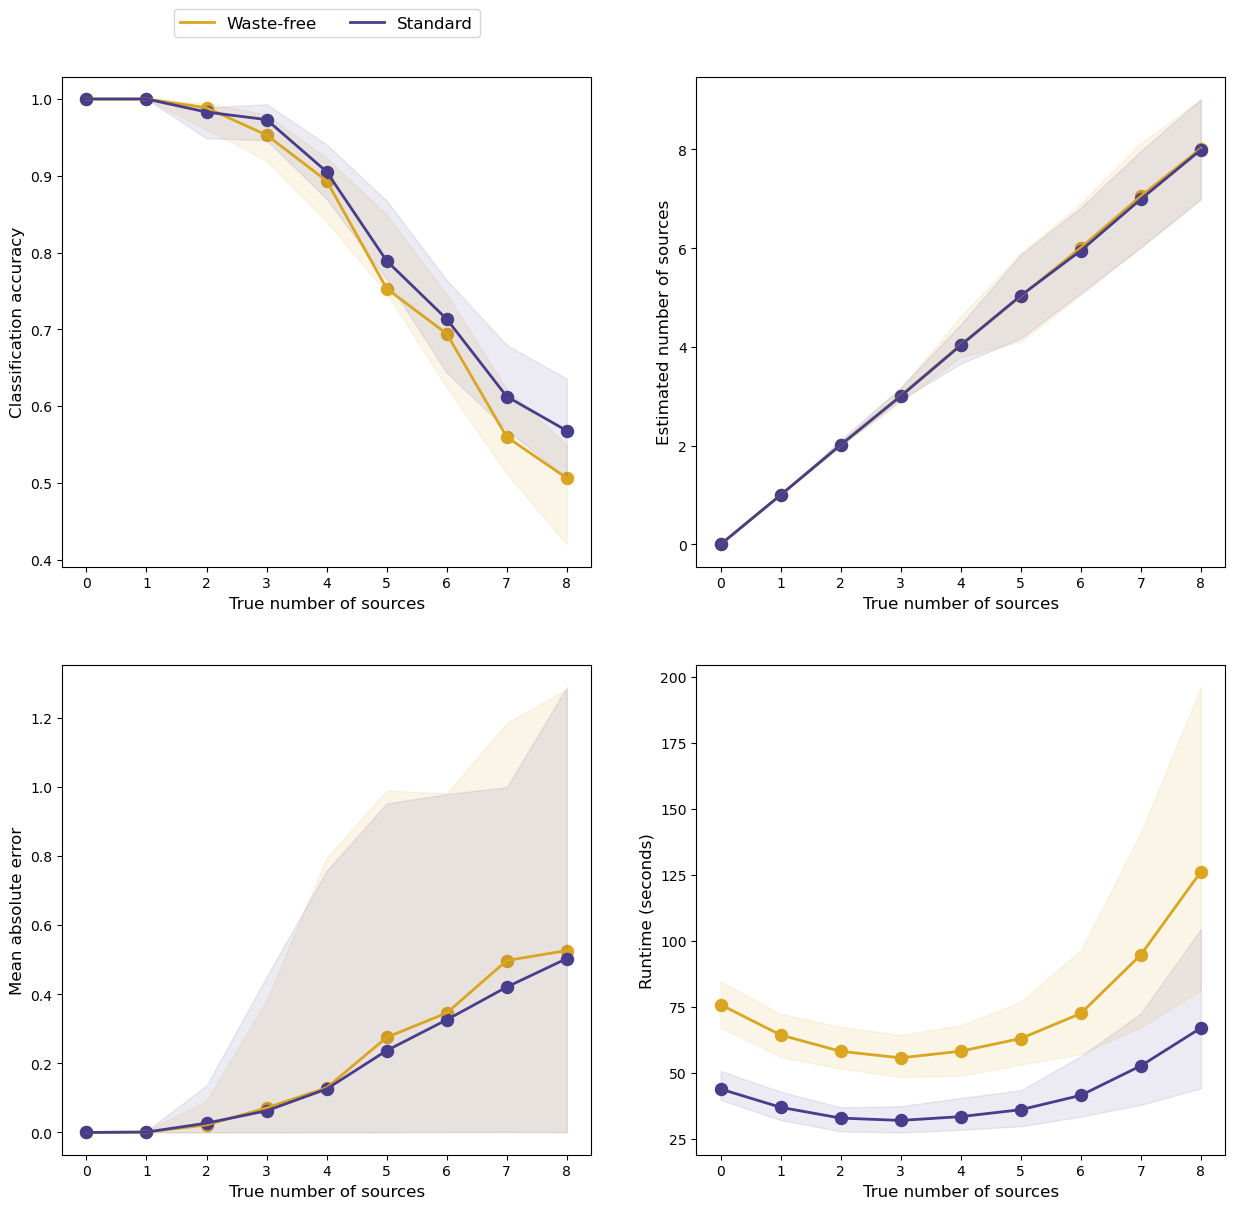

In [50]:
dot_size = 75
line_width = 2
text_size = 12

wf_color = "goldenrod"
std_color = "darkslateblue"

range_max_objects = torch.arange(max_objects, device="cpu")

fig2, [[fig2a,fig2b],[fig2c,fig2d]] = plt.subplots(nrows = 2, ncols = 2, figsize = (15,14))

fig2a.plot(range_max_objects, wf_prop_correct_by_count.cpu(), label = "Waste-free", color = wf_color, linewidth = line_width)
fig2a.scatter(range_max_objects, wf_prop_correct_by_count.cpu(), color = wf_color, s = dot_size)
fig2a.fill_between(range_max_objects, wf_bounds_prop_correct_by_count[:,0].cpu(), wf_bounds_prop_correct_by_count[:,1].cpu(), color = wf_color, alpha = 0.1)

fig2a.plot(range_max_objects, std_prop_correct_by_count.cpu(), label = "Standard", color = std_color, linewidth = line_width)
fig2a.scatter(range_max_objects, std_prop_correct_by_count.cpu(), color = std_color, s = dot_size)
fig2a.fill_between(range_max_objects, std_bounds_prop_correct_by_count[:,0].cpu(), std_bounds_prop_correct_by_count[:,1].cpu(), color = std_color, alpha = 0.1)

fig2a.set_xlabel("True number of sources", fontsize = text_size)
fig2a.set_ylabel("Classification accuracy", fontsize = text_size)
fig2a.legend(ncol=2, fancybox=True, loc="upper center", bbox_to_anchor=(0.5,1.155), fontsize = text_size)



fig2b.plot(range_max_objects, wf_mean_estimated_count_by_count.cpu(), color = wf_color, label = "Waste-free", linewidth = line_width)
fig2b.scatter(range_max_objects, wf_mean_estimated_count_by_count.cpu(), color = wf_color, s = dot_size)
fig2b.fill_between(range_max_objects, wf_bounds_posterior_mean_count_by_count[:,0].cpu(), wf_bounds_posterior_mean_count_by_count[:,1].cpu(), color = wf_color, alpha = 0.1)


fig2b.plot(range_max_objects, std_mean_estimated_count_by_count.cpu(), color = std_color, label = "Standard", linewidth = line_width)
fig2b.scatter(range_max_objects, std_mean_estimated_count_by_count.cpu(), color = std_color, s = dot_size)
fig2b.fill_between(range_max_objects, std_bounds_posterior_mean_count_by_count[:,0].cpu(), std_bounds_posterior_mean_count_by_count[:,1].cpu(), color = std_color, alpha = 0.1)
fig2b.set_xlabel("True number of sources", fontsize = text_size)
fig2b.set_ylabel("Estimated number of sources", fontsize = text_size)


# fig2c.plot(range_max_objects, (wf_mae_by_count + wf_mae_by_count[0]).cpu(), label = "Waste-free", color = wf_color, linewidth = line_width)
# fig2c.scatter(range_max_objects, wf_mae_by_count.cpu(), color = wf_color, s = dot_size)
# fig2c.fill_between(range_max_objects, wf_bounds_mae_by_count[:,0].cpu(), wf_bounds_mae_by_count[:,1].cpu(), color = wf_color, alpha = 0.1)

# fig2c.plot(range_max_objects, (std_mae_by_count + std_mae_by_count[0]).cpu(), label = "Standard", color = std_color, linewidth = line_width)
# fig2c.scatter(range_max_objects, std_mae_by_count.cpu(), color = std_color, s = dot_size)
# fig2c.fill_between(range_max_objects, std_bounds_mae_by_count[:,0].cpu(), std_bounds_mae_by_count[:,1].cpu(), color = std_color, alpha = 0.1)
# fig2c.set_xlabel("True number of sources", fontsize = text_size)
# fig2c.set_ylabel("Mean absolute error", fontsize = text_size)


fig2c.plot(range_max_objects, (wf_mae_by_count).cpu(), label = "Waste-free", color = wf_color, linewidth = line_width)
fig2c.scatter(range_max_objects, wf_mae_by_count.cpu(), color = wf_color, s = dot_size)
fig2c.fill_between(range_max_objects, wf_bounds_mae_by_count[:,0].cpu(), wf_bounds_mae_by_count[:,1].cpu(), color = wf_color, alpha = 0.1)

fig2c.plot(range_max_objects, (std_mae_by_count).cpu(), label = "Standard", color = std_color, linewidth = line_width)
fig2c.scatter(range_max_objects, std_mae_by_count.cpu(), color = std_color, s = dot_size)
fig2c.fill_between(range_max_objects, std_bounds_mae_by_count[:,0].cpu(), std_bounds_mae_by_count[:,1].cpu(), color = std_color, alpha = 0.1)
fig2c.set_xlabel("True number of sources", fontsize = text_size)
fig2c.set_ylabel("Mean absolute error", fontsize = text_size)


#fig2d.scatter(true_total_observed_flux, setting2_std_posterior_mean_total_flux,color = std_color)
#fig2d.scatter(true_total_observed_flux, setting2_wf_posterior_mean_total_flux,color = wf_color)


fig2d.plot(range_max_objects, (std_mean_runtime_by_count).cpu(), label = "Standard", color = std_color, linewidth = line_width)
fig2d.scatter(range_max_objects, std_mean_runtime_by_count.cpu(), color = std_color, s = dot_size)
fig2d.fill_between(range_max_objects, std_bounds_runtime_by_count[:,0].cpu(), std_bounds_runtime_by_count[:,1].cpu(), color = std_color, alpha = 0.1)

fig2d.plot(range_max_objects, (wf_mean_runtime_by_count).cpu(), label = "Standard", color = wf_color, linewidth = line_width)
fig2d.scatter(range_max_objects, wf_mean_runtime_by_count.cpu(), color = wf_color, s = dot_size)
fig2d.fill_between(range_max_objects, wf_bounds_runtime_by_count[:,0].cpu(), wf_bounds_runtime_by_count[:,1].cpu(), color = wf_color, alpha = 0.1)
fig2d.set_xlabel("True number of sources", fontsize = text_size)
fig2d.set_ylabel("Runtime (seconds)", fontsize = text_size)


<Axes: xlabel='True number of sources', ylabel='Classification accuracy'>

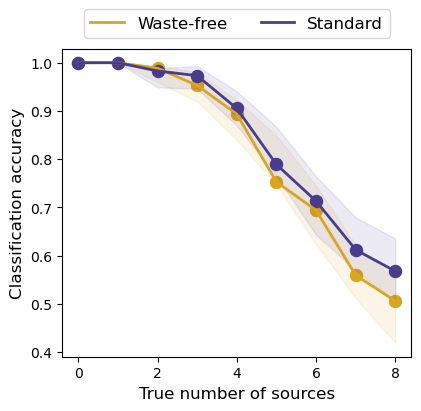

In [99]:
##PLOTS FOR SLIDES 
fig2a_both = plt.figure(figsize = (4.5,4))

plt.plot(range_max_objects, wf_prop_correct_by_count.cpu(), label = "Waste-free", color = wf_color, linewidth = line_width)
plt.scatter(range_max_objects, wf_prop_correct_by_count.cpu(), color = wf_color, s = dot_size)
plt.fill_between(range_max_objects, wf_bounds_prop_correct_by_count[:,0].cpu(), wf_bounds_prop_correct_by_count[:,1].cpu(), color = wf_color, alpha = 0.1)

plt.plot(range_max_objects, std_prop_correct_by_count.cpu(), label = "Standard", color = std_color, linewidth = line_width)
plt.scatter(range_max_objects, std_prop_correct_by_count.cpu(), color = std_color, s = dot_size)
plt.fill_between(range_max_objects, std_bounds_prop_correct_by_count[:,0].cpu(), std_bounds_prop_correct_by_count[:,1].cpu(), color = std_color, alpha = 0.1)

plt.xlabel("True number of sources", fontsize = text_size)
plt.ylabel("Classification accuracy", fontsize = text_size)
plt.legend(ncol=2, fancybox=True, loc="upper center", bbox_to_anchor=(0.5,1.155), fontsize = text_size)
plt.savefig('../setting2_plots/setting2_fig1a_both.png', dpi = 500)

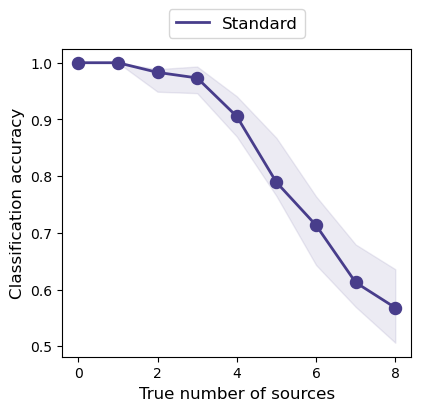

In [100]:
fig2a_std = plt.figure(figsize = (4.5,4))


plt.plot(range_max_objects, std_prop_correct_by_count.cpu(), label = "Standard", color = std_color, linewidth = line_width)
plt.scatter(range_max_objects, std_prop_correct_by_count.cpu(), color = std_color, s = dot_size)
plt.fill_between(range_max_objects, std_bounds_prop_correct_by_count[:,0].cpu(), std_bounds_prop_correct_by_count[:,1].cpu(), color = std_color, alpha = 0.1)

plt.xlabel("True number of sources", fontsize = text_size)
plt.ylabel("Classification accuracy", fontsize = text_size)
plt.legend(ncol=2, fancybox=True, loc="upper center", bbox_to_anchor=(0.5,1.155), fontsize = text_size)
plt.savefig('../setting2_plots/setting2_fig1a_std.png', dpi = 500)

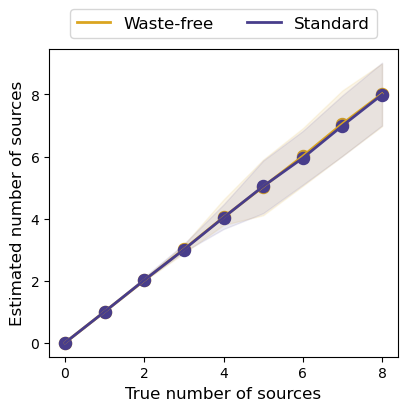

In [101]:
fig2b_both = plt.figure(figsize = (4.5,4))

plt.plot(range_max_objects, wf_mean_estimated_count_by_count.cpu(), color = wf_color, label = "Waste-free", linewidth = line_width)
plt.scatter(range_max_objects, wf_mean_estimated_count_by_count.cpu(), color = wf_color, s = dot_size)
plt.fill_between(range_max_objects, wf_bounds_posterior_mean_count_by_count[:,0].cpu(), wf_bounds_posterior_mean_count_by_count[:,1].cpu(), color = wf_color, alpha = 0.1)


plt.plot(range_max_objects, std_mean_estimated_count_by_count.cpu(), color = std_color, label = "Standard", linewidth = line_width)
plt.scatter(range_max_objects, std_mean_estimated_count_by_count.cpu(), color = std_color, s = dot_size)
plt.fill_between(range_max_objects, std_bounds_posterior_mean_count_by_count[:,0].cpu(), std_bounds_posterior_mean_count_by_count[:,1].cpu(), color = std_color, alpha = 0.1)
plt.xlabel("True number of sources", fontsize = text_size)
plt.ylabel("Estimated number of sources", fontsize = text_size)
plt.legend(ncol=2, fancybox=True, loc="upper center", bbox_to_anchor=(0.5,1.155), fontsize = text_size)

plt.savefig('../setting2_plots/setting2_fig1b_both.png', dpi = 500)

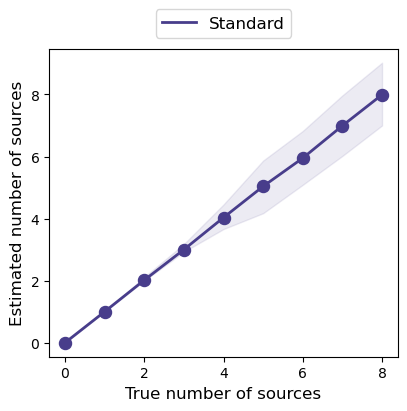

In [102]:
fig2b_both = plt.figure(figsize = (4.5,4))



plt.plot(range_max_objects, std_mean_estimated_count_by_count.cpu(), color = std_color, label = "Standard", linewidth = line_width)
plt.scatter(range_max_objects, std_mean_estimated_count_by_count.cpu(), color = std_color, s = dot_size)
plt.fill_between(range_max_objects, std_bounds_posterior_mean_count_by_count[:,0].cpu(), std_bounds_posterior_mean_count_by_count[:,1].cpu(), color = std_color, alpha = 0.1)
plt.xlabel("True number of sources", fontsize = text_size)
plt.ylabel("Estimated number of sources", fontsize = text_size)
plt.legend(ncol=2, fancybox=True, loc="upper center", bbox_to_anchor=(0.5,1.155), fontsize = text_size)

plt.savefig('../setting2_plots/setting2_fig1b_std.png', dpi = 500)

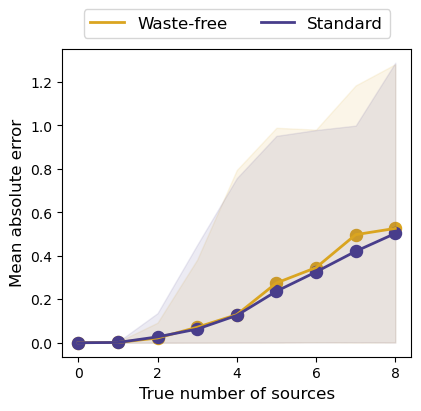

In [103]:
fig2c_both = plt.figure(figsize = (4.5,4))


plt.plot(range_max_objects, (wf_mae_by_count).cpu(), label = "Waste-free", color = wf_color, linewidth = line_width)
plt.scatter(range_max_objects, wf_mae_by_count.cpu(), color = wf_color, s = dot_size)
plt.fill_between(range_max_objects, wf_bounds_mae_by_count[:,0].cpu(), wf_bounds_mae_by_count[:,1].cpu(), color = wf_color, alpha = 0.1)

plt.plot(range_max_objects, (std_mae_by_count).cpu(), label = "Standard", color = std_color, linewidth = line_width)
plt.scatter(range_max_objects, std_mae_by_count.cpu(), color = std_color, s = dot_size)
plt.fill_between(range_max_objects, std_bounds_mae_by_count[:,0].cpu(), std_bounds_mae_by_count[:,1].cpu(), color = std_color, alpha = 0.1)
plt.xlabel("True number of sources", fontsize = text_size)
plt.ylabel("Mean absolute error", fontsize = text_size)
plt.legend(ncol=2, fancybox=True, loc="upper center", bbox_to_anchor=(0.5,1.155), fontsize = text_size)

plt.savefig('../setting2_plots/setting2_fig1c_both.png', dpi = 500)

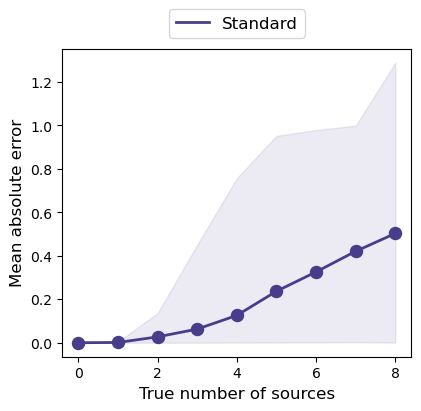

In [104]:
fig2c_std = plt.figure(figsize = (4.5,4))

plt.plot(range_max_objects, (std_mae_by_count).cpu(), label = "Standard", color = std_color, linewidth = line_width)
plt.scatter(range_max_objects, std_mae_by_count.cpu(), color = std_color, s = dot_size)
plt.fill_between(range_max_objects, std_bounds_mae_by_count[:,0].cpu(), std_bounds_mae_by_count[:,1].cpu(), color = std_color, alpha = 0.1)
plt.xlabel("True number of sources", fontsize = text_size)
plt.ylabel("Mean absolute error", fontsize = text_size)
plt.legend(ncol=2, fancybox=True, loc="upper center", bbox_to_anchor=(0.5,1.155), fontsize = text_size)

plt.savefig('../setting2_plots/setting2_fig1c_std.png', dpi = 500)

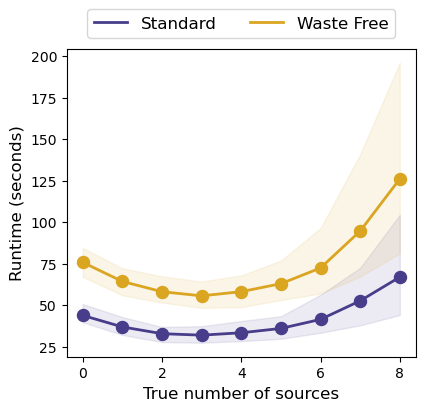

In [105]:
fig2d_both = plt.figure(figsize = (4.5,4))

plt.plot(range_max_objects, (std_mean_runtime_by_count).cpu(), label = "Standard", color = std_color, linewidth = line_width)
plt.scatter(range_max_objects, std_mean_runtime_by_count.cpu(), color = std_color, s = dot_size)
plt.fill_between(range_max_objects, std_bounds_runtime_by_count[:,0].cpu(), std_bounds_runtime_by_count[:,1].cpu(), color = std_color, alpha = 0.1)

plt.plot(range_max_objects, (wf_mean_runtime_by_count).cpu(), label = "Waste Free", color = wf_color, linewidth = line_width)
plt.scatter(range_max_objects, wf_mean_runtime_by_count.cpu(), color = wf_color, s = dot_size)
plt.fill_between(range_max_objects, wf_bounds_runtime_by_count[:,0].cpu(), wf_bounds_runtime_by_count[:,1].cpu(), color = wf_color, alpha = 0.1)
plt.xlabel("True number of sources", fontsize = text_size)
plt.ylabel("Runtime (seconds)", fontsize = text_size)
plt.legend(ncol=2, fancybox=True, loc="upper center", bbox_to_anchor=(0.5,1.155), fontsize = text_size)

plt.savefig('../setting2_plots/setting2_fig1d_both.png', dpi = 500)

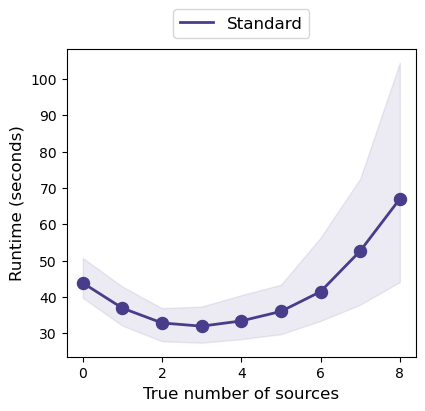

In [106]:
fig2d_std = plt.figure(figsize = (4.5,4))

plt.plot(range_max_objects, (std_mean_runtime_by_count).cpu(), label = "Standard", color = std_color, linewidth = line_width)
plt.scatter(range_max_objects, std_mean_runtime_by_count.cpu(), color = std_color, s = dot_size)
plt.fill_between(range_max_objects, std_bounds_runtime_by_count[:,0].cpu(), std_bounds_runtime_by_count[:,1].cpu(), color = std_color, alpha = 0.1)


plt.xlabel("True number of sources", fontsize = text_size)
plt.ylabel("Runtime (seconds)", fontsize = text_size)
plt.legend(ncol=2, fancybox=True, loc="upper center", bbox_to_anchor=(0.5,1.155), fontsize = text_size)

plt.savefig('../setting2_plots/setting2_fig1d_std.png', dpi = 500)